<a href="https://colab.research.google.com/github/JonasHagstrom79/QMLSupportVectorMachines/blob/main/QMLSupportVectorMachines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def clouds(num_points=100):
  centers = [(1,1), (-1,-1)]
  spreads = [0.5, 0.7]
  labels = [-1, 1]

  x = []
  y = []
  for center, spread, label in zip(centers, spreads, labels):
    x += np.random.multivariate_normal(center, spread * np.identity(2), num_points).tolist()
    y += [label] * num_points

  return x, y

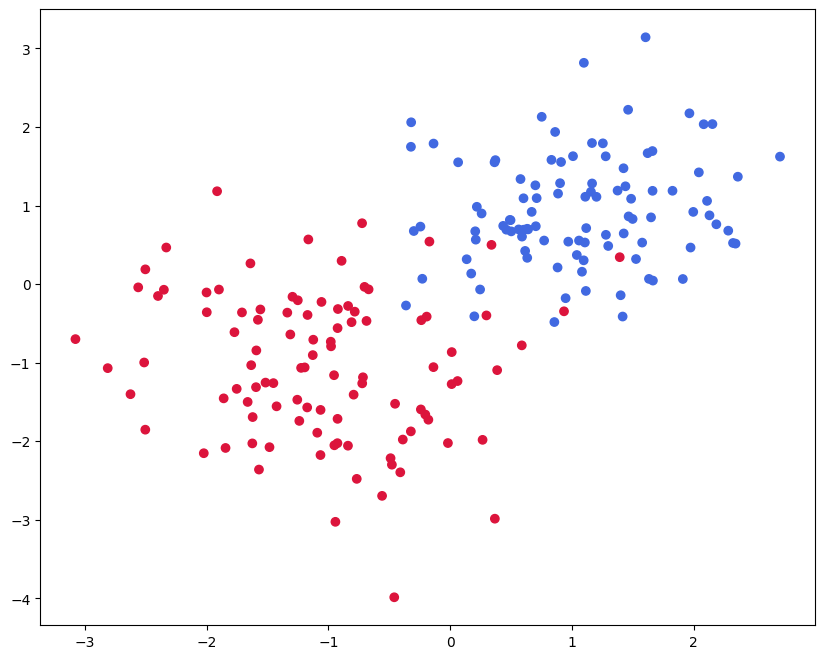

In [2]:
x, y = clouds(100)

colors = ["crimson" if label == 1 else "royalblue" for label in y]
plt.figure(figsize=(10,8))
plt.scatter(np.array(x)[:,0], np.array(x)[:,1], color=colors);

In [3]:
# Defining the loss function

def loss(support_vector, x, y, penalty=1e5):
  w = support_vector[1:]
  b = support_vector[0]

  norm = np.linalg.norm(w) **2
  constraint = sum(max(0, 1 - y[i] * (np.dot(w, x[i]) - b)) for i in range(len(y)))

  return norm + penalty * constraint

In [4]:
from scipy.optimize import minimize

# Initialize the optimizer with L-BFGS-B method
result = minimize(
    lambda sv: loss(sv, x, y),  # The function to minimize
    x0=np.random.random(3),     # Initial guess
    method='L-BFGS-B',          # Specify the optimization method
    bounds=None                 # You can add bounds if needed, e.g. [(0, 1), (0, 1), (0, 1)]
)

support_vector = result.x

In [5]:
# Classify our new points
def classify(point, support_vector):
  w = support_vector[1:]
  b = support_vector[0]
  return np.sign(np.dot(w, point) + b)

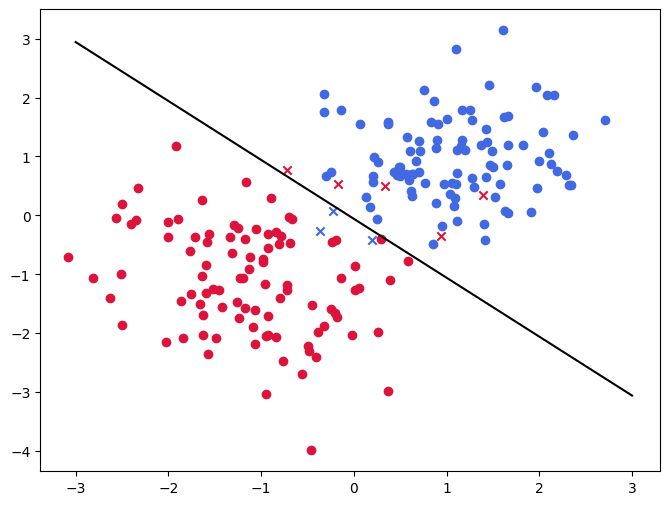

In [6]:
# Predict
predicted = [classify(point, support_vector) for point in x]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, predicted)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3,3, num=100)
x2 = -1 / w[1] * (w[1] * x1 + b)
plt.plot(x1, x2, "k-");

In [8]:
# You can just use the sklearn package
from sklearn.svm import SVC

model = SVC()
model.fit(x, y)

sk_predict = model.predict(x)

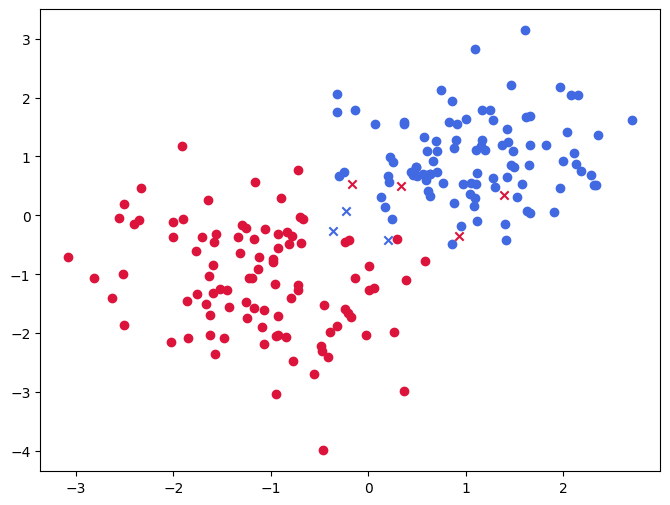

In [9]:
# Plot the results
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, sk_predict)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

In [10]:
# Non-linear data
def circle():
  num_points = 250
  points = 1 -2 * np.random.random((num_points, 2))

  radius = 0.6
  labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]

  return points, labels

Text(0, 0.5, '$x_2$')

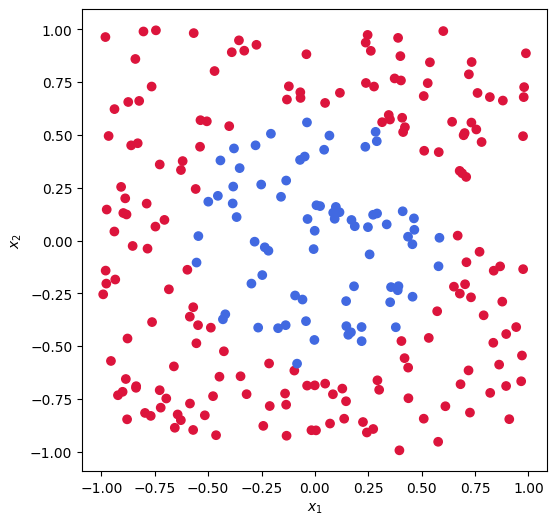

In [11]:
# Plot the results
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], color=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [ ]:
# Här är jag 05:09 Support Vector Machines